# Дипломный проект 
# Бриф 1. «Лаборатории исследований гражданского общества». Государственные деньги у НКО


В нашем распоряжении есть дамп данных обо всех НКО России, в котором содержится информация о получении государственных грантов,госконтрактов и субсидий, регионе и дате регистрации, а также ОКВЭД (классификатор экономической деятельности).
НКО хотят повысить свои шансы на получение гранта. Для этого им важно понять, что именно может повлиять на это.
Наша цель — спрогнозировать вероятность получения грантов от государства/госконтрактов для организации в зависимости от её характеристик.

Цель проекта — проверить, есть ли зависимость вероятности получения
грантов от государства/госконтрактов:
* от региона регистрации организации;
* от возраста организации;
* от экономической деятельности организации.

In [109]:
#Импортируем всякое полезное
import pandas as pd
import json
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import spearmanr
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn import linear_model
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
import optuna
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression, SGDRegressor


### Загрузка данных

In [2]:
#Прочитаем данные
data1 = pd.read_json('data/ngo_dump_01.json', lines=True)
data2 = pd.read_json('data/ngo_dump_02.json', lines=True)
data3 = pd.read_json('data/ngo_dump_03.json', lines=True)
data4 = pd.read_json('data/ngo_dump_04.json', lines=True)
data5 = pd.read_json('data/ngo_dump_05.json', lines=True)
data6 = pd.read_json('data/ngo_dump_06.json', lines=True)
data7 = pd.read_json('data/ngo_dump_07.json', lines=True)
data8 = pd.read_json('data/ngo_dump_08.json', lines=True)
data9 = pd.read_json('data/ngo_dump_09.json', lines=True)
data10 = pd.read_json('data/ngo_dump_10.json', lines=True)
data11 = pd.read_json('data/ngo_dump_11.json', lines=True)
data12 = pd.read_json('data/ngo_dump_12.json', lines=True)
data13 = pd.read_json('data/ngo_dump_13.json', lines=True)
data14 = pd.read_json('data/ngo_dump_14.json', lines=True)
data15 = pd.read_json('data/ngo_dump_15.json', lines=True)

In [3]:
#Объединим всё в датасет
data = pd.concat([data1, data2, data3,data4,data5,data6,data7,data8,data9,data10,data11,data12,data13,data14,data15], axis=0, ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747034 entries, 0 to 747033
Data columns (total 38 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   minjustRegNum       462302 non-null  object 
 1   regionName          747009 non-null  object 
 2   logo                0 non-null       float64
 3   statusDetail        747034 non-null  object 
 4   fullName            747034 non-null  object 
 5   dateReg             321416 non-null  object 
 6   minjustForm         462302 non-null  object 
 7   charter             0 non-null       float64
 8   minjustStatus       462302 non-null  object 
 9   ogrn                747034 non-null  int64  
 10  opf                 747034 non-null  object 
 11  oktmo               747034 non-null  object 
 12  egrulStatus         747034 non-null  object 
 13  mainOkved           747034 non-null  object 
 14  regionCode          747034 non-null  int64  
 15  incomeTotal         747034 non-nul

In [4]:
data.head()

,minjustRegNum,regionName,logo,statusDetail,fullName,dateReg,minjustForm,charter,minjustStatus,ogrn,...,hasRegionalSupport,addOkved,okato,okfs,website_punycode,shortName,dateOgrn,predecessors,socialMedia,reports
0,7814061218,Санкт-Петербург,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...",МЕЖРЕГИОНАЛЬНАЯ АНТРОПОСОФСКАЯ МЕДИЦИНСКАЯ АСС...,None,"Объединения (союз, ассоциация) юридических лиц",NaN,Зарегистрирована,1207800141790,...,False,[],"{'name': None, 'code': None}","{'name': None, 'code': None}",None,"""АМА""",{'$date': '2020-10-30T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...",[]
1,7714017452,Москва,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...","ФОНД ""СОДЕЙСТВИЕ ДУХОВНОМУ РАЗВИТИЮ ЧЕЛОВЕКА ""...",None,Некоммерческий фонд,NaN,Зарегистрирована,1207700349152,...,False,"[{'name': 'Издание книг', 'code': '58.11', 've...","{'name': None, 'code': None}","{'name': None, 'code': None}",None,"ФОНД ""УНИВЕРСАЛИСТ М""",{'$date': '2020-09-23T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...","[{'localUrl': 'http://cdnx.h5.crftr.net/f/4,18..."
2,7814170160,Санкт-Петербург,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...","КОЛЛЕГИЯ АДВОКАТОВ ""САНКТ-ПЕТЕРБУРГСКАЯ КОЛЛЕГ...",None,Коллегия адвокатов,NaN,Зарегистрирована,1207800011430,...,False,[],"{'name': None, 'code': None}","{'name': None, 'code': None}",None,None,{'$date': '2020-02-03T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...",[]
3,None,Москва,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...","ТОВАРИЩЕСТВО СОБСТВЕННИКОВ НЕДВИЖИМОСТИ ""ЛУГИН...",None,None,NaN,None,1207700348976,...,False,[{'name': 'Аренда и управление собственным или...,"{'name': None, 'code': None}","{'name': None, 'code': None}",None,"ТСН ""ЛУГИНИНО ПАРК""",{'$date': '2020-09-23T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...",[]
4,7814052913,Санкт-Петербург,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...","АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ""ЦЕНТР С...",None,Автономная некоммерческая организация,NaN,Зарегистрирована,1207800081500,...,False,[{'name': 'Исследование конъюнктуры рынка и из...,"{'name': None, 'code': None}","{'name': None, 'code': None}",None,"АНО ""ЦЕНТР ""ПЕТЕРБУРГФОРУМ""",{'$date': '2020-07-08T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...",[]


Переложим данные в отдельный файл, для удобства

In [5]:
data.to_csv('data/full_data.csv', index=False)

In [2]:
#Прочитаем данные
df = pd.read_csv('data/full_data.csv', low_memory=False)
df.head()

,minjustRegNum,regionName,logo,statusDetail,fullName,dateReg,minjustForm,charter,minjustStatus,ogrn,...,hasRegionalSupport,addOkved,okato,okfs,website_punycode,shortName,dateOgrn,predecessors,socialMedia,reports
0,7814061218,Санкт-Петербург,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...",МЕЖРЕГИОНАЛЬНАЯ АНТРОПОСОФСКАЯ МЕДИЦИНСКАЯ АСС...,NaN,"Объединения (союз, ассоциация) юридических лиц",NaN,Зарегистрирована,1207800141790,...,False,[],"{'name': None, 'code': None}","{'name': None, 'code': None}",NaN,"""АМА""",{'$date': '2020-10-30T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...",[]
1,7714017452,Москва,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...","ФОНД ""СОДЕЙСТВИЕ ДУХОВНОМУ РАЗВИТИЮ ЧЕЛОВЕКА ""...",NaN,Некоммерческий фонд,NaN,Зарегистрирована,1207700349152,...,False,"[{'name': 'Издание книг', 'code': '58.11', 've...","{'name': None, 'code': None}","{'name': None, 'code': None}",NaN,"ФОНД ""УНИВЕРСАЛИСТ М""",{'$date': '2020-09-23T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...","[{'localUrl': 'http://cdnx.h5.crftr.net/f/4,18..."
2,7814170160,Санкт-Петербург,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...","КОЛЛЕГИЯ АДВОКАТОВ ""САНКТ-ПЕТЕРБУРГСКАЯ КОЛЛЕГ...",NaN,Коллегия адвокатов,NaN,Зарегистрирована,1207800011430,...,False,[],"{'name': None, 'code': None}","{'name': None, 'code': None}",NaN,NaN,{'$date': '2020-02-03T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...",[]
3,NaN,Москва,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...","ТОВАРИЩЕСТВО СОБСТВЕННИКОВ НЕДВИЖИМОСТИ ""ЛУГИН...",NaN,NaN,NaN,NaN,1207700348976,...,False,[{'name': 'Аренда и управление собственным или...,"{'name': None, 'code': None}","{'name': None, 'code': None}",NaN,"ТСН ""ЛУГИНИНО ПАРК""",{'$date': '2020-09-23T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...",[]
4,7814052913,Санкт-Петербург,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...","АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ""ЦЕНТР С...",NaN,Автономная некоммерческая организация,NaN,Зарегистрирована,1207800081500,...,False,[{'name': 'Исследование конъюнктуры рынка и из...,"{'name': None, 'code': None}","{'name': None, 'code': None}",NaN,"АНО ""ЦЕНТР ""ПЕТЕРБУРГФОРУМ""",{'$date': '2020-07-08T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...",[]


### Очистка данных

In [3]:
#Выведем процент пропусков в столбцах
df.isna().mean()*100

minjustRegNum          38.146457
regionName              0.003347
logo                  100.000000
statusDetail            0.000000
fullName                0.000000
dateReg                56.974381
minjustForm            38.279516
charter               100.000000
minjustStatus          38.114999
ogrn                    0.000000
opf                     0.000000
oktmo                   0.000000
egrulStatus             0.000000
mainOkved               0.000000
regionCode              0.000000
incomeTotal             0.000000
email                  98.907948
incomeDetail            0.000000
administrators          0.000000
inn                     0.348579
okpo                   53.491140
originDate              0.000000
website                99.292402
dateLiquid             46.460134
address                 0.000000
successors              0.000000
okogu                   0.000000
kpp                     0.490205
hasRegionalSupport      0.000000
addOkved                0.000000
okato     

Можем удалить столбцы, которые содержат более 35% пропусков

In [4]:
cols_nan_percent = df.isna().mean()*100
cols_to_drop = list(cols_nan_percent[cols_nan_percent > 35].index)
df = df.drop(cols_to_drop, axis=1)

In [5]:
#shortName - тоже считаем ненужным, как и записи, содержащие хотя бы один пропуск
df = df.drop('shortName', axis=1)
df = df.dropna(how='any', axis=0)

In [6]:
#Проверим пропуски
df.isna().sum().sum()

0

In [7]:
#Удалим дубликаты, если они вдруг есть
df = df.drop_duplicates()

### Анализ данных

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 743296 entries, 0 to 747033
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   regionName          743296 non-null  object 
 1   statusDetail        743296 non-null  object 
 2   fullName            743296 non-null  object 
 3   ogrn                743296 non-null  int64  
 4   opf                 743296 non-null  object 
 5   oktmo               743296 non-null  object 
 6   egrulStatus         743296 non-null  object 
 7   mainOkved           743296 non-null  object 
 8   regionCode          743296 non-null  int64  
 9   incomeTotal         743296 non-null  float64
 10  incomeDetail        743296 non-null  object 
 11  administrators      743296 non-null  object 
 12  inn                 743296 non-null  float64
 13  originDate          743296 non-null  object 
 14  address             743296 non-null  object 
 15  successors          743296 non-null  ob

#### Преобразование признаков

1. Проверим информативность признаков

In [9]:
#Определим уникальные признаки и признаки с повторяющимися значениями
low_info = []
for i in df.columns:
    top_freq = df[i].value_counts(normalize=True).max()
    nunique_ratio = df[i].nunique()/df[i].count()
    if top_freq > 0.95:
        low_info.append(i)
    if nunique_ratio>0.95:
        low_info.append(i)
low_info

['statusDetail',
 'ogrn',
 'incomeTotal',
 'incomeDetail',
 'inn',
 'successors',
 'hasRegionalSupport',
 'predecessors',
 'socialMedia']

Удалим ненужное

In [10]:
df['administrators'].value_counts()
df = df.drop('administrators', axis=1)

cols_to_drop = ['addOkved', 'okogu', 'okato', 'okfs', 'predecessors', 'socialMedia', 'reports', 'successors', 'ogrn']
df = df.drop(cols_to_drop, axis=1)

df = df.drop(['fullName', 'inn', 'kpp'], axis=1)

df = df.drop('address', axis=1)

df = df.drop(['oktmo', 'egrulStatus'], axis=1)

2. Определим все регионы, в которых зарегистрированано менее 4000 НКО, в отдельную категорию

In [11]:
#Выделим категорию other
regions = df['regionName'].value_counts(ascending=False)
mask = regions>=4000
region_list = list(regions[mask].index)
df['regionName'] = df['regionName'].apply(lambda x: x if x in region_list else 'other')

In [12]:
df['regionName'].value_counts()

regionName
Москва                  79319
other                   55523
Московская область      37868
Санкт-Петербург         31446
Краснодарский край      23324
                        ...  
Мурманская область       4355
Республика Коми          4341
Республика Мордовия      4276
Астраханская область     4224
Брянская область         4223
Name: count, Length: 62, dtype: int64

3. Извлечем из столбца statusDetail текущий статус НКО

In [13]:
status = []
for i in df['statusDetail']:
    detail_list = i.split(':')
    status.append(detail_list[3][2:-2])
df['status'] = status
df['status'].value_counts()

status
Действующая                727335
Недействующая                8028
Ликвидируется                6488
В состоянии банкротства       783
Реорганизуется                662
Name: count, dtype: int64

In [14]:
#Удалим исходный столбец
df = df.drop('statusDetail', axis=1)

4. Извлечем из столбца opf вид организационно-правовой формы НКО

In [15]:
#Находим ОПФ 
opf = []
for i in df['opf']:
    detail_list = i.split(':')
    opf.append(detail_list[1][2:-9])
df['opf'] = opf
df['opf'].value_counts()

opf
Общественные организации                                                                          75356
Общественная или религиозная организация (объединение)                                            71437
Гаражные и гаражно-строительные кооперативы                                                       49858
Автономные некоммерческие организации                                                             46114
Потребительский кооператив                                                                        39351
                                                                                                  ...  
Юридические лица, являющиеся некоммерческими организациями, не включенные в другие группировки        1
Государственные академии наук                                                                         1
Колхоз                                                                                                1
Арендное предприятие в форме акционерного общества закрытого

Выделим НКО с малочисленной ОПФ в отдельную категорию

In [16]:
#Выделим категорию other для малочисленных ОПФ
n_opf = df['opf'].value_counts(ascending=False)
mask = n_opf>=3000
nko_list = list(n_opf[mask].index)
df['opf'] = df['opf'].apply(lambda x: x if x in nko_list else 'other')
df['opf'].value_counts()

opf
Общественные организации                                                                        75356
Общественная или религиозная организация (объединение)                                          71437
Гаражные и гаражно-строительные кооперативы                                                     49858
other                                                                                           49684
Автономные некоммерческие организации                                                           46114
Потребительский кооператив                                                                      39351
Религиозные организации                                                                         33715
ОБЩЕСТВЕННАЯ ОРГАНИЗАЦИЯ                                                                        32481
Профсоюзные организации                                                                         28021
Товарищества собственников недвижимости                                       

Объединим одинаковые формы

In [17]:
#Функция для объединения дублирующих категорий в одну
def opf(x):
    if x=='ОБЩЕСТВЕННАЯ ОРГАНИЗАЦИЯ':
        x='Общественные организации'
    elif x=='Ассоциация (союз)':
        x='Ассоциации (союзы)'
    elif x=='Некоммерческое партнерство':
        x='Некоммерческие партнерства'
    elif x=='Фонд':
        x='Фонды'
    elif x=='Садоводческое, огородническое или дачное некоммерческое товарищество' or x=='Садоводческие, огороднические или дачные некоммерческие партнерства':
        x='Садоводческие, огороднические или дачные некоммерческие товарищества'
    elif x=='Потребительский кооператив' or x=='Потребительские общества':
        x='Потребительские кооперативы'
    elif x=='Товарищество собственников жилья' or x=='Товарищества собственников жилья':
        x='Товарищества собственников недвижимости'
    elif x=='Автономная некоммерческая организаци' or x=='Автономная некоммерческая организация':
        x='Автономные некоммерческие организации'
    elif x=='other':
        x='Прочая некоммерческая организация'
    return x

In [18]:
#Применяем функцию 
df['opf'] = df['opf'].apply(opf)
df['opf'].value_counts()

opf
Общественные организации                                                                        107837
Общественная или религиозная организация (объединение)                                           71437
Товарищества собственников недвижимости                                                          64461
Потребительские кооперативы                                                                      62735
Автономные некоммерческие организации                                                            57133
Прочая некоммерческая организация                                                                57035
Гаражные и гаражно-строительные кооперативы                                                      49858
Некоммерческие партнерства                                                                       39116
Садоводческие, огороднические или дачные некоммерческие товарищества                             33796
Религиозные организации                                              

5. Из столбца mainOkved выделим вид деятельности НКО

In [19]:
df['mainOkved'].value_counts()

mainOkved
{'name': None, 'code': None, 'version': 'ОК 029-2001 (КДЕС Ред. 1)'}                                                                                       201837
{'name': 'Деятельность прочих общественных организаций, не включенных в другие группировки', 'code': '94.99', 'version': 'ОК 029-2014 (КДЕС Ред. 2)'}       76862
{'name': 'Деятельность стоянок для транспортных средств', 'code': '52.21.24', 'version': 'ОК 029-2014 (КДЕС Ред. 2)'}                                       38247
{'name': 'Деятельность религиозных организаций', 'code': '94.91', 'version': 'ОК 029-2014 (КДЕС Ред. 2)'}                                                   31456
{'name': 'Управление эксплуатацией жилого фонда за вознаграждение или на договорной основе', 'code': '68.32.1', 'version': 'ОК 029-2014 (КДЕС Ред. 2)'}     29643
                                                                                                                                                            ...  
{'name': 'Торговля

In [20]:
#Выделим информацию о виде деятельности
okved = []
for i in df['mainOkved']:
    detail_list = i.split(':')
    okved.append(detail_list[1][2:-9])
df['okved'] = okved
df['okved'].value_counts()

okved
on                                                                                                                                        201837
Деятельность прочих общественных организаций, не включенных в другие группировки                                                          100495
Деятельность стоянок для транспортных средств                                                                                              38247
Деятельность религиозных организаций                                                                                                       32503
Управление эксплуатацией жилого фонда за вознаграждение или на договорной основе                                                           29643
                                                                                                                                           ...  
Производство металлических дверей и окон                                                                                    

Для многих организаций вид деятельности не указан, либо является уникальным, поэтому информативность признака под вопросом. 


In [21]:
#Выделим категорию other для малочисленных видов деятельности
n_okved = df['okved'].value_counts(ascending=False)
mask = n_okved>=3000
nko_list = list(n_okved[mask].index)
df['okved'] = df['okved'].apply(lambda x: x if x in nko_list else 'other')
df['okved'] = df['okved'].apply(lambda x: x if x!='on' else 'other')

Просуммируем организации с неуказанным видом деятельности

In [22]:
df['okved'] = df['okved'].apply(lambda x: x if x!='Деятельность прочих общественных организаций, не включенных в другие группировки' else 'other')
df['okved'].value_counts()

okved
other                                                                                                                               454780
Деятельность стоянок для транспортных средств                                                                                        38247
Деятельность религиозных организаций                                                                                                 32503
Управление эксплуатацией жилого фонда за вознаграждение или на договорной основе                                                     29643
Деятельность профессиональных союзов                                                                                                 25200
Управление эксплуатацией нежилого фонда за вознаграждение или на договорной основе                                                   22989
Управление недвижимым имуществом за вознаграждение или на договорной основе                                                          20858
Управление эксплуатац

Большая часть данных отсутствует, удалим признак

In [23]:
df = df.drop(['mainOkved', 'okved'], axis=1)

6. Узнаем для каждой НКО ее возраст

In [24]:
df['originDate'].value_counts()

originDate
{'$date': '1996-02-26T00:00:00.000Z'}    3527
{'$date': '2002-06-28T00:00:00.000Z'}    1337
{'$date': '1995-06-16T00:00:00.000Z'}    1255
{'$date': '1996-01-29T00:00:00.000Z'}    1208
{'$date': '1999-06-30T00:00:00.000Z'}    1039
                                         ... 
{'$date': '1974-06-18T00:00:00.000Z'}       1
{'$date': '1960-09-27T00:00:00.000Z'}       1
{'$date': '2008-08-30T00:00:00.000Z'}       1
{'$date': '1971-11-15T00:00:00.000Z'}       1
{'$date': '1987-12-05T00:00:00.000Z'}       1
Name: count, Length: 16998, dtype: int64

In [25]:
#Выделяем дату из признака и формируем новый столбец
origin_date = []
for i in df['originDate']:
    detail_list = i.split(':')
    origin_date.append(detail_list[1][2:-3])
df['origin_date'] = origin_date
df['origin_date'] = pd.to_datetime(df['origin_date'])
df['age'] = datetime.datetime.now().year-df['origin_date'].dt.year

In [26]:
#Удаляем исходные признаки
df = df.drop(['originDate', 'origin_date'], axis=1)

#Дата регистрации ОГРН не характеризует НКО
df = df.drop('dateOgrn', axis=1)

7. Выделим в отдельные признаки количество полученых грантов, федеральных субсидий и госконтрактов с помощью десериализации признака incomeDetail

In [27]:
#Функция для извлечения количества грантов
def des_gr(x):
    x = x.replace("'", '"')
    dict = json.loads(x)
    grants = dict['grants']
    count = grants['totalCount']   
    return count

In [28]:
#Применяем функцию и создаем новый признак
df['grants'] = df['incomeDetail'].apply(des_gr)
df['grants'] = df['grants'].apply(lambda x: 1 if x>0 else 0)

In [29]:
#Функция для извлечения количества федеральных субсидий
def des_sub(x):
    x = x.replace("'", '"')
    dict = json.loads(x)
    subs = dict['fedSubsidies']
    count = subs['totalCount']   
    return count

In [30]:
#Применяем функцию и создаем новый признак
df['fedSub'] = df['incomeDetail'].apply(des_sub)
df['fedSub'] = df['fedSub'].apply(lambda x: 1 if x>0 else 0)

In [31]:
#Функция для извлечения количества госконтрактов
def des_cont(x):
    x = x.replace("'", '"')
    dict = json.loads(x)
    c44 = dict['contracts44']
    c_44_count = c44['totalCount'] 
    c223 = dict['contracts223']
    c_223_count = c223['totalCount']
    c94 = dict['contracts94']
    c_94_count = c94['totalCount']
    count = c_44_count+c_223_count+c_94_count      
    return count

In [32]:
#Применяем функцию и создаем новый признак
df['contracts'] = df['incomeDetail'].apply(des_cont)
df['contracts'] = df['contracts'].apply(lambda x: 1 if x>0 else 0)

In [33]:
#Удалим исходный столбец
df = df.drop('incomeDetail', axis=1)

In [34]:
df.head()

,regionName,opf,regionCode,incomeTotal,hasRegionalSupport,status,age,grants,fedSub,contracts
0,Санкт-Петербург,Ассоциации (союзы),78,0.0,False,Действующая,6,0,0,0
1,Москва,Фонды,77,0.0,False,Действующая,6,0,0,0
2,Санкт-Петербург,Коллегии адвокатов,78,0.0,False,Действующая,6,0,0,0
3,Москва,Товарищества собственников недвижимости,77,0.0,False,Действующая,6,0,0,0
4,Санкт-Петербург,Автономные некоммерческие организации,78,0.0,False,Действующая,6,0,0,0


In [35]:
#Запишем очищенный датасет в файл
df.to_csv('data/data_cleaned.csv', index=False)

Таким образом, мы располагаем сведениями о регионе регистрации НКО, организационной форме, возрасте, статусе, наличии региональной поддержки, а также количестве полученных грантов и их суммарному размеру.
Дальнейшее исследование будет проводиться в двух направлениях: 
- Решим задачу классификации с целью определения вероятности для НКО получить грант/субсидию/контракт.
- Решим задачу регрессии, чтобы как можно точнее предсказать размер прибыли для подходящих НКО.

#### Визуализация зависимостей между признаками

In [36]:
#Прочитаем данные
df = pd.read_csv('data/data_cleaned.csv')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743296 entries, 0 to 743295
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   regionName          743296 non-null  object 
 1   opf                 743296 non-null  object 
 2   regionCode          743296 non-null  int64  
 3   incomeTotal         743296 non-null  float64
 4   hasRegionalSupport  743296 non-null  bool   
 5   status              743296 non-null  object 
 6   age                 743296 non-null  int64  
 7   grants              743296 non-null  int64  
 8   fedSub              743296 non-null  int64  
 9   contracts           743296 non-null  int64  
dtypes: bool(1), float64(1), int64(5), object(3)
memory usage: 51.7+ MB


Для начала выясним, насколько важен признак названия региона, сравнив диаграммы названия и кода в отношении количества полученных грантов.

[Text(0.5, 1.0, 'Распределение суммарного количества грантов по регионам'),
 Text(0.5, 0, 'Количество грантов'),
 Text(0, 0.5, 'Регион')]

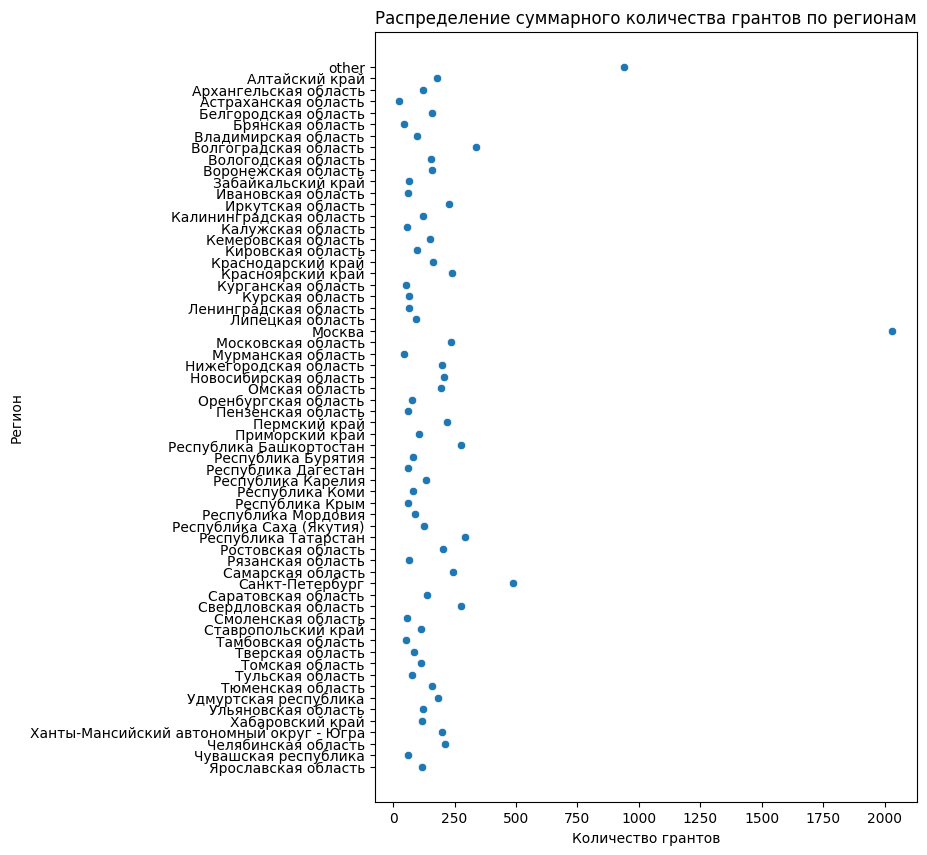

In [38]:
#Группируем данные и строим диаграмму рассеяния по регионам
grouped_name = df.groupby('regionName', as_index=False)['grants'].sum()
fig = plt.figure(figsize = (7, 10))
scatter = sns.scatterplot(grouped_name, y='regionName', x='grants')
scatter.set(title='Распределение суммарного количества грантов по регионам', xlabel='Количество грантов', ylabel='Регион')

[Text(0.5, 1.0, 'Распределение суммарного количества грантов по регионам'),
 Text(0.5, 0, 'Количество грантов'),
 Text(0, 0.5, 'Код региона')]

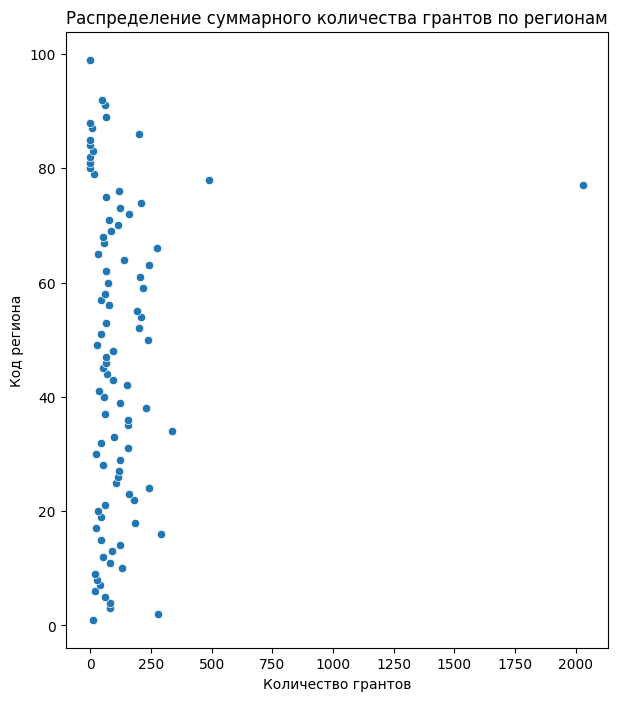

In [39]:
#Группируем данные и строим диаграмму рассеяния по регионам
grouped_code = df.groupby('regionCode', as_index=False)['grants'].sum()
fig = plt.figure(figsize = (7, 8))
scatter = sns.scatterplot(grouped_code, y='regionCode', x='grants')
scatter.set(title='Распределение суммарного количества грантов по регионам', xlabel='Количество грантов', ylabel='Код региона')

Мы видим аналогичное распределение, поэтому от признака названия региона отказываемся, как от дублирующей информации.
По поводу взаимосвязи региона НКО с признаком получения грантов можно сказать, что лидирующую позицию с большим отрывом занимает Москва (около 2000 грантов на регион). На втором месте Санкт-Петербург, а остальные регионы распределены в узкой полосе до 250 грантов суммарно. Таким образом, по данному графику можно сказать, что положительно на возможность получения гранта влияет расположение НКО в Москве, чуть менее в культурной столице, а для других регионов место регистрации особенно не влияет на результат.

In [40]:
#Удаляем неактуальный столбец
df = df.drop('regionName', axis=1)

Давайте рассмотрим зависимость получения грантов от организационно-правовой формы предприятия

[Text(0.5, 1.0, 'Зависимость суммарного количества грантов от ОПФ НКО'),
 Text(0.5, 0, 'Количество грантов'),
 Text(0, 0.5, 'Организационно-правовая форма')]

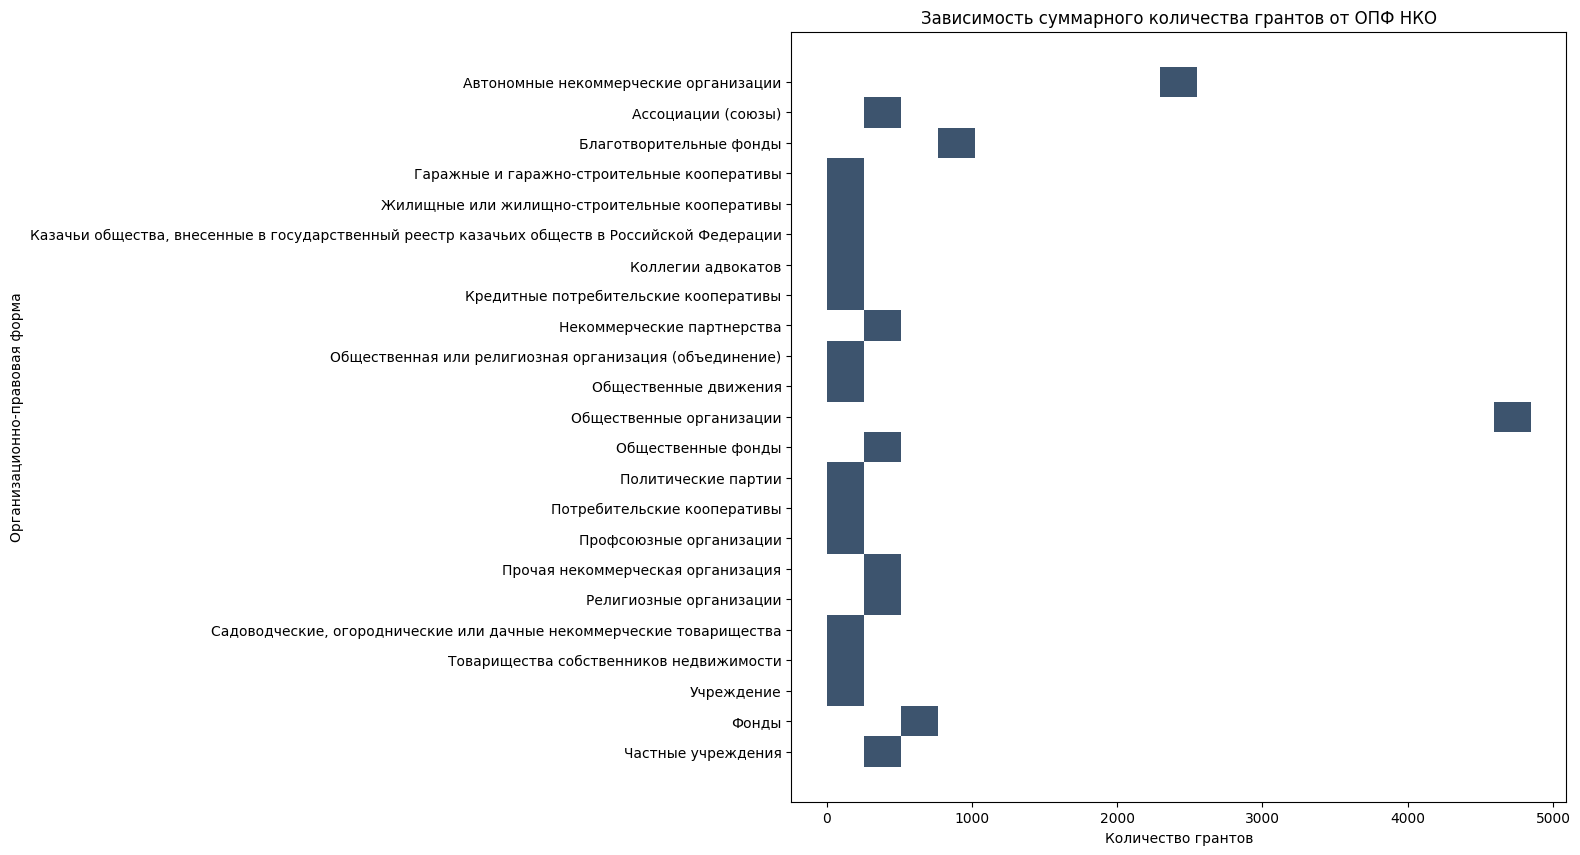

In [41]:
#Группируем данные и строим график распределения грантов среди ОПФ НКО
grouped_opf = df.groupby('opf', as_index=False)['grants'].sum()
fig = plt.figure(figsize = (10, 10))
hist = sns.histplot(grouped_opf, y='opf', x='grants')
hist.set(title='Зависимость суммарного количества грантов от ОПФ НКО', xlabel='Количество грантов', ylabel='Организационно-правовая форма')

Мы видим, что наибольшей поддержкой пользуются общественные организации, на втором месте - АНКО, а на третьем месте - благотворительные фонды. Остальные организации находятся примерно в одной области до 500 грантов на категори. Это говорит о том, что существует некоторая зависимость, при которой гранты чаще получают организации с определенными ОПФ

Рассмотрим признак возраста организаций

[Text(0.5, 1.0, 'Распределение НКО по возрасту'),
 Text(0.5, 0, 'Возраст'),
 Text(0, 0.5, 'Количество НКО')]

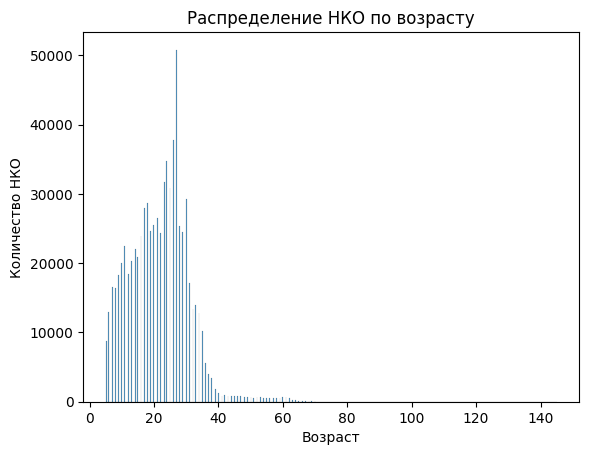

In [42]:
histplot = sns.histplot(df, x='age')
histplot.set(title='Распределение НКО по возрасту', xlabel='Возраст', ylabel='Количество НКО')

Вероятно, присутствуют выбросы. Избавимся от них по методу Тьюки

In [43]:
#Функция для создания очищенного от выбросов датасета
def outliers(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quartile_3-quartile_1
    low_bound = quartile_1-(iqr*1.5)
    up_bound = quartile_3+(iqr*1.5)
    cleaned = data[(x>low_bound)&(x<up_bound)]
    return cleaned

In [44]:
#Применим функцию к датасету
df = outliers(df, 'age')

Text(0, 0.5, 'Возраст')

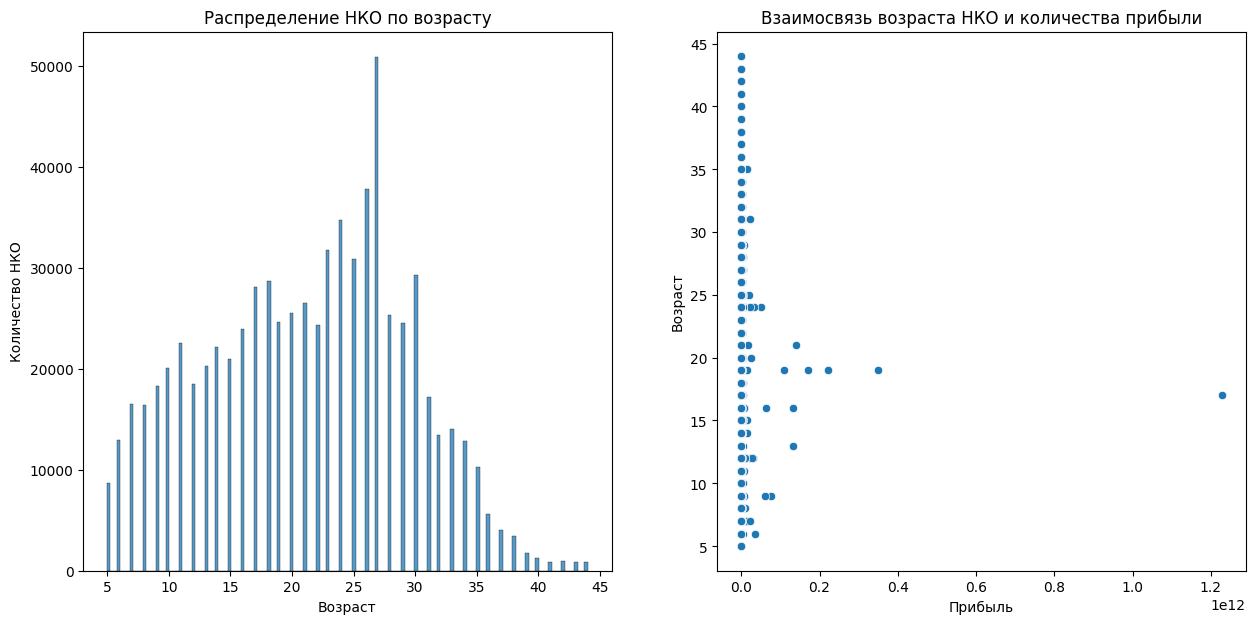

In [45]:
#Построим гистограмму распределения возраста организаций и диаграмму зависимости размера поддержки и возраста
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15, 7))
histplot = sns.histplot(df, x='age', ax=axes[0])
histplot.set_title('Распределение НКО по возрасту')
histplot.set_xlabel('Возраст')
histplot.set_ylabel('Количество НКО')
scatter = sns.scatterplot(df, x='incomeTotal', y='age', ax=axes[1])
scatter.set_title('Взаимосвязь возраста НКО и количества прибыли')
scatter.set_xlabel('Прибыль')
scatter.set_ylabel('Возраст')

Теперь видно, что возраст организаций варьирует в адекватном диапазоне, большая часть НКО существует от 10 до 30 лет на момент исследования. В отношении целевых признаков (в данном случае суммарная прибыль) возраст НКО является важным фактором. На диаграмме рассеяния видно, что значительная часть предприятий, получивших госконтракты, имеет определенный возраст.

[Text(0.5, 1.0, 'Среднее количество грантов на категорию статуса НКО'),
 Text(0.5, 0, 'Статус'),
 Text(0, 0.5, 'Гранты (среднее)')]

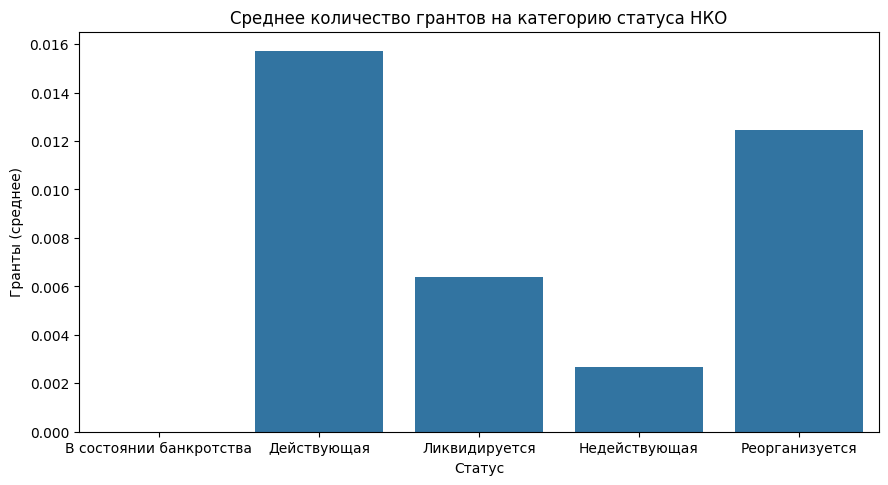

In [46]:
#Группируем данные и строим столбчатую диаграмму
grouped = df.groupby('status', as_index=False)['grants'].mean()
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes((1,1,1,1))
barplot = sns.barplot(grouped, x='status', y='grants', ax=ax)
barplot.set(title='Среднее количество грантов на категорию статуса НКО', xlabel='Статус', ylabel='Гранты (среднее)')

На графике мы видим различное среднее количество грантов для категорий статуса предприятия, таким образом, это может служить одним из признаков, характеризующих НКО в контексте поставленной задачи.
Построим тепловую карту зависимости целевого признака от региона регистрации и возраста организации.

[Text(0.5, 1.0, 'Объем федерального субсидирования по регионам и возрасту НКО'),
 Text(0.5, 23.52222222222222, 'Возраст НКО'),
 Text(50.722222222222214, 0.5, 'Код региона')]

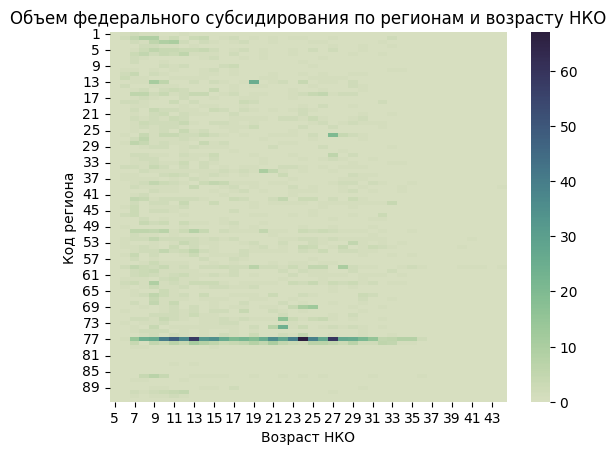

In [47]:
#Строим сводную таблицу
pivot_table = pd.pivot_table(df, values='fedSub', aggfunc='sum', index='regionCode', columns='age', fill_value=0)
#Строим тепловую карту
cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
heatmap = sns.heatmap(pivot_table, cmap=cmap)
heatmap.set(title='Объем федерального субсидирования по регионам и возрасту НКО', xlabel='Возраст НКО', ylabel='Код региона')

Как и раньше было сказано, наибольшим суммарным объемом субсидирования обеспечены предприятия московского региона возрастом от 10 до 30 лет.

#### Кодирование признаков

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 731313 entries, 0 to 743295
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   opf                 731313 non-null  object 
 1   regionCode          731313 non-null  int64  
 2   incomeTotal         731313 non-null  float64
 3   hasRegionalSupport  731313 non-null  bool   
 4   status              731313 non-null  object 
 5   age                 731313 non-null  int64  
 6   grants              731313 non-null  int64  
 7   fedSub              731313 non-null  int64  
 8   contracts           731313 non-null  int64  
dtypes: bool(1), float64(1), int64(5), object(2)
memory usage: 50.9+ MB


Для начала присвоим булевой переменной hasRegionalSupport числовые значения

In [50]:
#Присваиваем значения True=1, False=0 и удаляем исходный столбец
df['regSub'] = df['hasRegionalSupport'].apply(lambda x: 1 if x==True else 0)
df = df.drop('hasRegionalSupport', axis=1)

Для признака opf применим двоичное кодирование, так как категорий больше 15

In [51]:
#Кодируем признак и присоединяем к датасету
encoder = ce.BinaryEncoder()
opf_bin = encoder.fit_transform(df['opf'])
df = pd.concat([df, opf_bin], axis=1)
df.head()

,opf,regionCode,incomeTotal,status,age,grants,fedSub,contracts,regSub,opf_0,opf_1,opf_2,opf_3,opf_4
0,Ассоциации (союзы),78,0.0,Действующая,6,0,0,0,0,0,0,0,0,1
1,Фонды,77,0.0,Действующая,6,0,0,0,0,0,0,0,1,0
2,Коллегии адвокатов,78,0.0,Действующая,6,0,0,0,0,0,0,0,1,1
3,Товарищества собственников недвижимости,77,0.0,Действующая,6,0,0,0,0,0,0,1,0,0
4,Автономные некоммерческие организации,78,0.0,Действующая,6,0,0,0,0,0,0,1,0,1


In [52]:
#Удаляем исходный столбец
df = df.drop('opf', axis=1)

Для признака status будем применять однократное кодирование, так как категорий всего пять

In [53]:
#Кодируем признак и присоединяем к датасету
encoder = ce.OneHotEncoder()
st_bin = encoder.fit_transform(df['status'])
df = pd.concat([df, st_bin], axis=1)
df.head()

,regionCode,incomeTotal,status,age,grants,fedSub,contracts,regSub,opf_0,opf_1,opf_2,opf_3,opf_4,status_1,status_2,status_3,status_4,status_5
0,78,0.0,Действующая,6,0,0,0,0,0,0,0,0,1,1,0,0,0,0
1,77,0.0,Действующая,6,0,0,0,0,0,0,0,1,0,1,0,0,0,0
2,78,0.0,Действующая,6,0,0,0,0,0,0,0,1,1,1,0,0,0,0
3,77,0.0,Действующая,6,0,0,0,0,0,0,1,0,0,1,0,0,0,0
4,78,0.0,Действующая,6,0,0,0,0,0,0,1,0,1,1,0,0,0,0


In [54]:
#Удаляем исходный столбец
df = df.drop('status', axis=1)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 731313 entries, 0 to 743295
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   regionCode   731313 non-null  int64  
 1   incomeTotal  731313 non-null  float64
 2   age          731313 non-null  int64  
 3   grants       731313 non-null  int64  
 4   fedSub       731313 non-null  int64  
 5   contracts    731313 non-null  int64  
 6   regSub       731313 non-null  int64  
 7   opf_0        731313 non-null  int64  
 8   opf_1        731313 non-null  int64  
 9   opf_2        731313 non-null  int64  
 10  opf_3        731313 non-null  int64  
 11  opf_4        731313 non-null  int64  
 12  status_1     731313 non-null  int64  
 13  status_2     731313 non-null  int64  
 14  status_3     731313 non-null  int64  
 15  status_4     731313 non-null  int64  
 16  status_5     731313 non-null  int64  
dtypes: float64(1), int64(16)
memory usage: 100.4 MB


In [56]:
df.describe()

,regionCode,incomeTotal,age,grants,fedSub,contracts,regSub,opf_0,opf_1,opf_2,opf_3,opf_4,status_1,status_2,status_3,status_4,status_5
count,731313.000000,7.313130e+05,731313.000000,731313.000000,731313.000000,731313.000000,731313.000000,731313.000000,731313.000000,731313.000000,731313.000000,731313.000000,731313.000000,731313.000000,731313.000000,731313.000000,731313.000000
mean,48.799818,5.274359e+06,21.188282,0.015490,0.003930,0.032180,0.015398,0.241272,0.414319,0.589072,0.388412,0.617912,0.978540,0.008805,0.010734,0.000879,0.001042
std,23.516452,1.568689e+09,8.178778,0.123491,0.062566,0.176479,0.123131,0.427855,0.492604,0.492003,0.487389,0.485898,0.144912,0.093419,0.103048,0.029639,0.032263
min,1.000000,0.000000e+00,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,0.000000e+00,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,51.000000,0.000000e+00,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,70.000000,0.000000e+00,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,99.000000,1.227756e+12,44.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Статистический анализ

Выдвинем гипотезы о влиянии факторов на целевые переменные, но сначала необходимо выяснить их распределение. Проведем тесты на нормальность

In [57]:
#Формулируем гипотезы
H0 = 'Данные распределены нормально'
H1 = 'Данные не распределены нормально (мы отвергаем H0)'

#Устанавливаем уровень значимости
alpha = 0.05

In [58]:
#Тест Шапиро-Уилка
_, p = shapiro(df)
print('p=%.3f' % p)

# Интерпретация 
if p > alpha:
	print(H0)
else:
	print(H1)

p=0.000
Данные не распределены нормально (мы отвергаем H0)


In [59]:
#Тест Д'Агостино
_, p = normaltest(df)
print('p=%.3f' % p[0])

# Интерпретация 
if p[0] > alpha/2:
	print(H0)
else:
	print(H1)

p=0.000
Данные не распределены нормально (мы отвергаем H0)


Данные не имеют нормального распределения, а значит для проверки гипотез будем использовать непараметрические тесты.

Корреляционный тест будет проводиться по методу Спирмена, так как данные распределены ненормально. 
Проверим зависимость целевого признака суммарной прибыли от самого малочисленного статуса НКО (банкрот), поскольку на этапе преобразования и кодирования признаков были сомнения насчет его значимости.

In [60]:
#Выдвигаем гипотезы
H0 = 'Зависимость между признаками отсутствует'
H1 = 'Отвергаем нулевую гипотезу, зависимость существует'

In [61]:
#Корреляция Спирмена
corr, p = spearmanr(df['incomeTotal'], df['status_4'])
if p>alpha:
    print(f"{p} > {alpha}. {H0}.")
else:
    print(f"{p} <= {alpha}. {H1}.")

3.068014210753941e-38 <= 0.05. Отвергаем нулевую гипотезу, зависимость существует.


Для общей оценки коррелированности признаков построим матрицу корреляций по методу Спирмена

[Text(0.5, 1.0, 'Матрица корреляций Спирмена')]

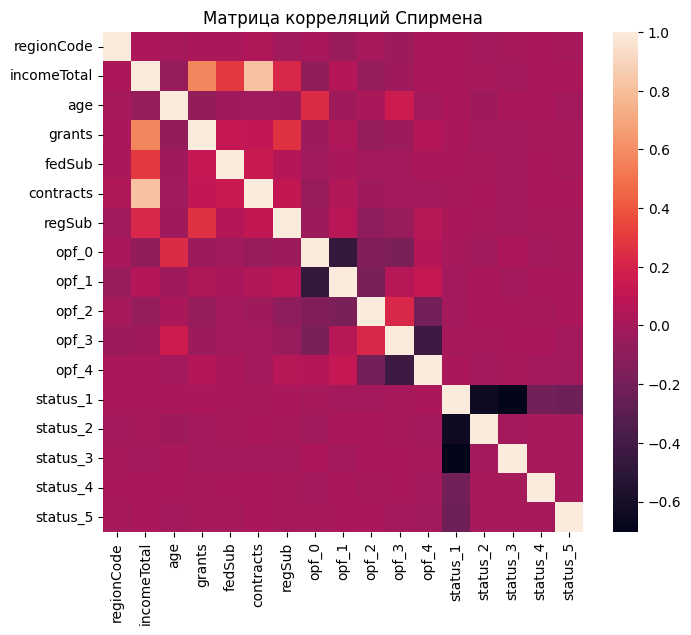

In [62]:
#Тепловая матрица корреляций Спирмена
fig = plt.figure(figsize=(6,5))
ax = fig.add_axes((1,1,1,1))
sns.heatmap(df.corr(method='spearman'),  ax=ax)
ax.set(title='Матрица корреляций Спирмена')

Как мы видим, мультиколлинеарность между факторами отсутствует. Можно отметить сильную связь признака contracts с целевой переменной incomeTotal, но это указывает скорее на важность признака. Между собой данные для обучения модели коррелируют нормально.

Чтобы в этом убедиться, разделим набор данных на обучающий X и целевые переменные, после чего повторно выведем матрицу корреляций только для факторов

In [63]:
#Делим выборку на данные для обучения и целевые переменные
X = df.drop(['incomeTotal', 'grants', 'fedSub', 'contracts'], axis=1) #набор для обучения
y_grants = df['grants'] #гранты
y_fedSub = df['fedSub'] #федеральные субсидии
y_contr = df['contracts'] #госконтракты

[Text(0.5, 1.0, 'Матрица корреляций для набора факторов')]

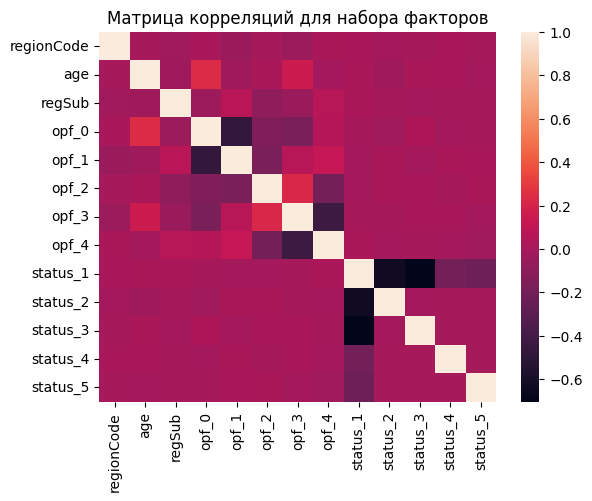

In [64]:
#Построим тепловую карту корреляций
heatmap = sns.heatmap(X.corr(method='spearman'))
heatmap.set(title='Матрица корреляций для набора факторов')

Избыточной зависимости между признаками нет, проведем также оценку значимости признаков с помощью хи-квадрат теста

<Axes: title={'center': 'Оценка значимости признаков по хи-квадрат'}>

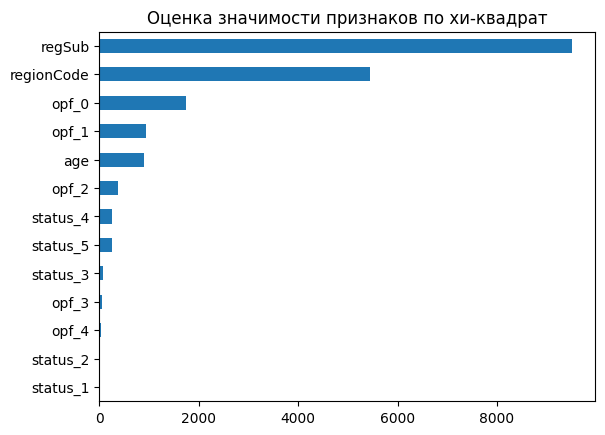

In [65]:
#Хи-квадрат тест
imp = pd.Series(chi2(X, y_contr)[0], index=X.columns)
imp.sort_values(inplace=True)
imp.plot(kind='barh', title='Оценка значимости признаков по хи-квадрат')

Как мы видим, ряд факторов имеют высокую значимость, особенно regSub и regionCode. 

Разделим выборки на тренировочный и тестовый наборы, отберем наиболее значимые признаки и произведем их нормализацию, после чего можно приступать к выбору и построению модели машинного обучения.

Так как стоит задача комплексная, наборов будет несколько. Мы хотим узнать вероятности получения каждой категории прибыли по отдельности, начнем с грантов

#### Предсказание вероятности получения гранта от государства

In [66]:
#Разбиваем выборку на тренировочную и тестовую, используя стратификацию по y по причине значительного дисбаланса классов
X_train, X_test, y_train, y_test = train_test_split(X, y_grants, test_size=0.3, stratify=y_grants, random_state=42)

Произведем отбор признаков с помощью SelectKBest и нормализуем данные с помощью MinMaxScaler

In [67]:
#Отбираем подходящие признаки
selector = SelectKBest(f_classif, k=7)
selector.fit(X_train, y_train)
selector.get_feature_names_out()
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

In [68]:
#Нормализуем данные
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train_sel)                           
X_train_scaled = scaler.transform(X_train_sel)   
X_test_scaled = scaler.transform(X_test_sel)

С целью уменьшить влияние дисбаланса выборки применим сэмплирование, а именно oversampling для увеличения количества наблюдений миноритарного класса

In [69]:
#Сэмплируем тренировочные данные
rov = RandomOverSampler(random_state=42)
X_train_s, y_train_s = rov.fit_resample(X_train_scaled, y_train)
y_train_s.value_counts()

grants
0    503989
1    503989
Name: count, dtype: int64

Теперь можем приступить к обучению модели. Перед нами стоит задача классификации, в качестве baseline используем логистическую регрессию.

* Logistic Regression

In [70]:
#Обучаем модель логистической регрессии и делаем предсказание
log_reg = linear_model.LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_s, y_train_s)
y_pred = log_reg.predict(X_test_scaled)

Так как классы сильно несбалансированы, в качестве метрик будем использовать balanced accuracy и f1-score weighted avg

In [71]:
#Вычисляем метрики
print(f'Accuracy: {round(metrics.balanced_accuracy_score(y_test, y_pred),3)}')
print(f'F1: {round(metrics.f1_score(y_test, y_pred, average="weighted"),3)}')

Accuracy: 0.754
F1: 0.857


Попробуем улучшить результат путем подбора оптимального порога вероятностей

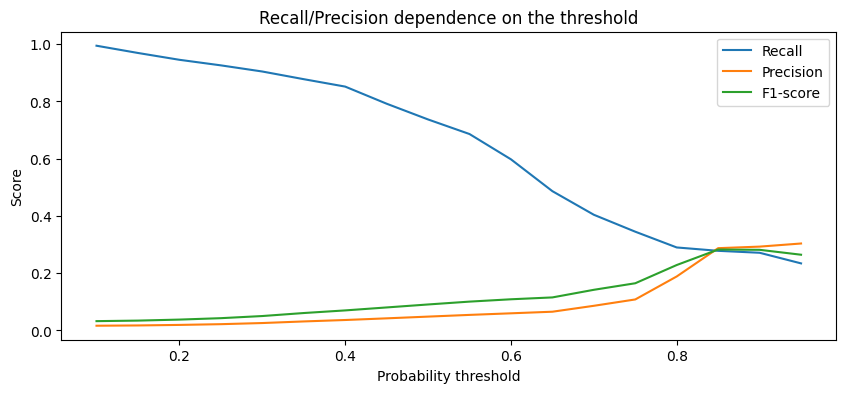

In [72]:
#Вычислим вероятности
y_test_proba_pred = log_reg.predict_proba(X_test_scaled)[:, 1]
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)

for threshold in thresholds:
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) 
ax.plot(thresholds, recall_scores, label='Recall')
ax.plot(thresholds, precision_scores, label='Precision')
ax.plot(thresholds, f1_scores, label='F1-score')
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend()

In [73]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.85
y_test_pred_opt_lr_grants = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Вычисляем метрики
lr_grants_accuracy = round(metrics.balanced_accuracy_score(y_test, y_test_pred_opt_lr_grants),3)
lr_grants_f1 = round(metrics.f1_score(y_test, y_test_pred_opt_lr_grants, average="weighted"),3) 
print(f'Accuracy: {lr_grants_accuracy}')
print(f'F1: {lr_grants_f1}')
print(metrics.classification_report(y_test, y_test_pred_opt_lr_grants))

Accuracy: 0.634
F1: 0.978
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    215996
           1       0.29      0.28      0.28      3398

    accuracy                           0.98    219394
   macro avg       0.64      0.63      0.64    219394
weighted avg       0.98      0.98      0.98    219394



Теперь будем использовать дерево решений для решения задачи

* Decision Tree Classifier

Для начала осуществим подбор гиперпараметров модели с помощью GridSearchCV

In [74]:
#Задаем пространства поиска гиперпараметров
parameters =  {'min_samples_leaf': list(np.linspace(2,15,5, dtype='int')), 
               'max_depth':list(np.linspace(1,30,20,dtype='int')), 
               'criterion':['entropy','gini']}
#Создаем и обучаем модель
model_cv = GridSearchCV(DecisionTreeClassifier(), 
                        parameters,
                        cv=3, scoring=('f1'), 
                        return_train_score=True)

model_cv.fit(X_train_scaled, y_train)
print(model_cv.best_params_)
print(model_cv.best_estimator_)
print(model_cv.best_score_)

{'criterion': 'entropy', 'max_depth': 14, 'min_samples_leaf': 2}
DecisionTreeClassifier(criterion='entropy', max_depth=14, min_samples_leaf=2)
0.028582905281907267


Обучим дерево решений на наилучших параметрах

In [75]:
#Обучаем модель дерева решений и делаем предсказание
dt = DecisionTreeClassifier(max_depth= 14, min_samples_leaf= 2, criterion= 'entropy', random_state=42)
dt.fit(X_train_s, y_train_s)
y_pred = dt.predict(X_test_scaled)
#Вычисляем метрики
print(f'Accuracy: {round(metrics.balanced_accuracy_score(y_test, y_pred),3)}')
print(f'F1: {round(metrics.f1_score(y_test, y_pred, average="weighted"),3)}')

Accuracy: 0.804
F1: 0.846


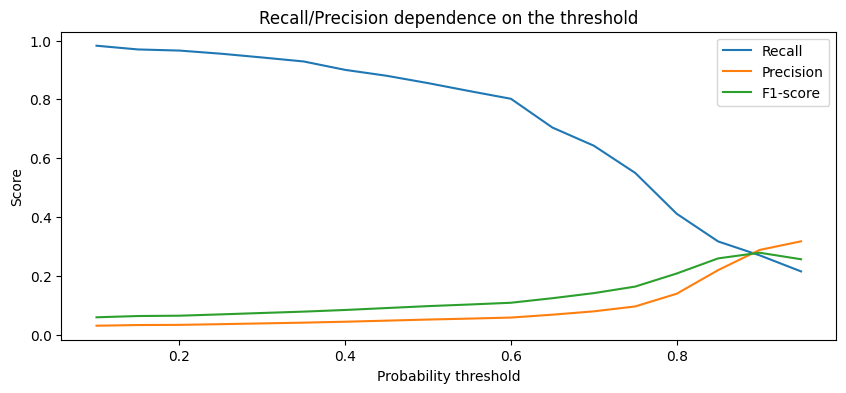

In [76]:
#Вычислим вероятности
y_test_proba_pred = dt.predict_proba(X_test_scaled)[:, 1]
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)

for threshold in thresholds:
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) 
ax.plot(thresholds, recall_scores, label='Recall')
ax.plot(thresholds, precision_scores, label='Precision')
ax.plot(thresholds, f1_scores, label='F1-score')
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend()

In [77]:
threshold_opt = 0.9
y_test_pred_opt_dt_grants = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Вычисляем метрики
dt_grants_accuracy = round(metrics.balanced_accuracy_score(y_test, y_test_pred_opt_dt_grants),3)
dt_grants_f1 = round(metrics.f1_score(y_test, y_test_pred_opt_dt_grants, average="weighted"),3) 
print(f'Accuracy: {dt_grants_accuracy}')
print(f'F1: {dt_grants_f1}')
print(metrics.classification_report(y_test, y_test_pred_opt_dt_grants))

Accuracy: 0.63
F1: 0.978
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    215996
           1       0.29      0.27      0.28      3398

    accuracy                           0.98    219394
   macro avg       0.64      0.63      0.63    219394
weighted avg       0.98      0.98      0.98    219394



Мы получили примерно такие же значения метрик, сбалансированная accuracy чуть ниже, а f1-мера чуть выше. Попробуем также сделать предсказание с помощью случайного леса, подбор гиперпараметров осуществим с помощью Optuna

* Random Forest Classifier

In [78]:
def optuna_rf(trial):
  #Задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 150, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  #Создаем модель
  model = RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  #Обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [81]:
%%time
#Создаем объект исследования
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
#Ищем лучшую комбинацию гиперпараметров
study.optimize(optuna_rf, n_trials=10)

[I 2026-01-03 20:01:40,260] A new study created in memory with name: RandomForestClassifier
[I 2026-01-03 20:02:51,268] Trial 0 finished with value: 0.00577019568489714 and parameters: {'n_estimators': 185, 'max_depth': 11, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.00577019568489714.
[I 2026-01-03 20:03:42,475] Trial 1 finished with value: 0.008756567425569177 and parameters: {'n_estimators': 159, 'max_depth': 21, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.008756567425569177.
[I 2026-01-03 20:04:45,647] Trial 2 finished with value: 0.008756567425569177 and parameters: {'n_estimators': 194, 'max_depth': 18, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.008756567425569177.
[I 2026-01-03 20:05:48,140] Trial 3 finished with value: 0.009501187648456057 and parameters: {'n_estimators': 193, 'max_depth': 18, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.009501187648456057.
[I 2026-01-03 20:06:42,351] Trial 4 finished with value: 0.0087576629550857 and p

CPU times: total: 9min 50s
Wall time: 9min 53s


In [82]:
#Обучаем модель случайного леса и делаем предсказание
rf = RandomForestClassifier(**study.best_params, random_state=42)
rf.fit(X_train_s, y_train_s)
y_pred = rf.predict(X_test_scaled)
#Вычисляем метрики
print('Accuracy: {:.2f}'.format(metrics.balanced_accuracy_score(y_test, y_pred)))
print('F1: {:.2f}'.format(metrics.f1_score(y_test, y_pred, average="weighted")))

Accuracy: 0.81
F1: 0.85


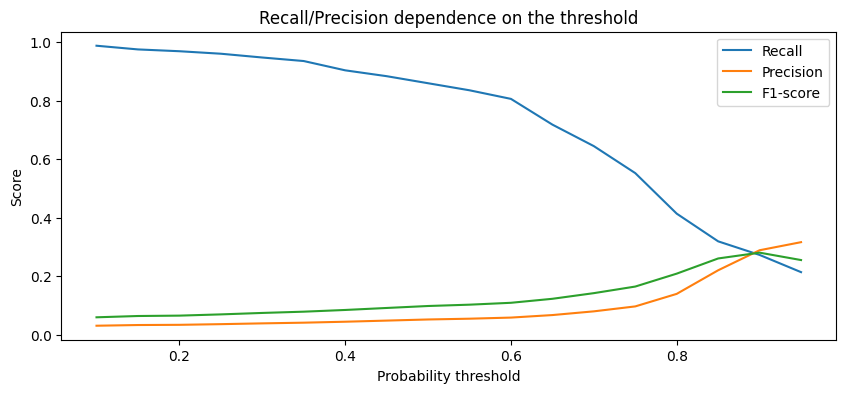

In [83]:
#Вычислим вероятности
y_test_proba_pred = rf.predict_proba(X_test_scaled)[:, 1]
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)

for threshold in thresholds:
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) 
ax.plot(thresholds, recall_scores, label='Recall')
ax.plot(thresholds, precision_scores, label='Precision')
ax.plot(thresholds, f1_scores, label='F1-score')
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend()

In [84]:
threshold_opt = 0.9
y_test_pred_opt_rf_grants = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Вычисляем метрики
rf_grants_accuracy = round(metrics.balanced_accuracy_score(y_test, y_test_pred_opt_rf_grants),3)
rf_grants_f1 = round(metrics.f1_score(y_test, y_test_pred_opt_rf_grants, average="weighted"),3) 
print(f'Accuracy: {rf_grants_accuracy}')
print(f'F1: {rf_grants_f1}')
print(metrics.classification_report(y_test, y_test_pred_opt_rf_grants))

Accuracy: 0.631
F1: 0.978
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    215996
           1       0.29      0.27      0.28      3398

    accuracy                           0.98    219394
   macro avg       0.64      0.63      0.63    219394
weighted avg       0.98      0.98      0.98    219394



[Text(0.5, 1.0, 'Матрица ошибок логистической регрессии')]

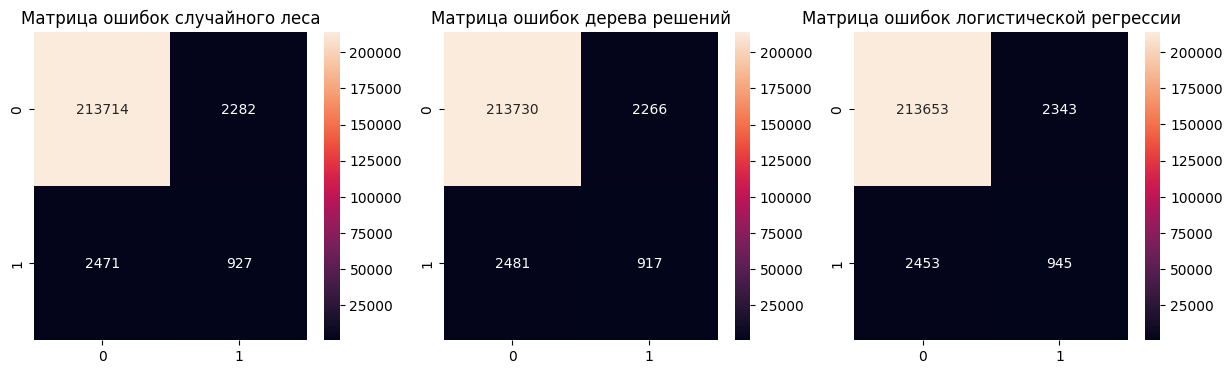

In [85]:
#Построим матрицы ошибок для моделей
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,4))
con_mat_rf = sns.heatmap(metrics.confusion_matrix(y_test, y_test_pred_opt_rf_grants), annot=True, fmt='', ax=axes[0])
con_mat_rf.set(title='Матрица ошибок случайного леса')
con_mat_dt = sns.heatmap(metrics.confusion_matrix(y_test, y_test_pred_opt_dt_grants), annot=True, fmt='', ax=axes[1])
con_mat_dt.set(title='Матрица ошибок дерева решений')
con_mat_lr = sns.heatmap(metrics.confusion_matrix(y_test, y_test_pred_opt_lr_grants), annot=True, fmt='', ax=axes[2])
con_mat_lr.set(title='Матрица ошибок логистической регрессии')

Как мы видим, логистическая регрессия, ансамбль и одиночное дерево дают примерно одинаковый результат, поэтому с точки зрения ресурсопотребления целесообразно использовать регрессию или дерево решений. Результат сам по себе не достаточно высокий, модель недообучена, данные сильно разрежены. Попробуем обучить модели логистической регрессии и дерева решений предсказывать вероятность получения любого вида государственной поддержки.

#### Предсказание вероятности получения государственной поддержки в виде грантов, субсидий, контрактов

In [86]:
#Формируем таргет
y = df['grants']+df['fedSub']+df['contracts']
y = y.apply(lambda x: 1 if x>0 else 0)
y.value_counts()

0    697142
1     34171
Name: count, dtype: int64

In [87]:
#Разбиваем выборку на тренировочную и тестовую, используя стратификацию по y по причине значительного дисбаланса классов
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [88]:
#Отбираем подходящие признаки
selector = SelectKBest(f_classif, k=7)
selector.fit(X_train, y_train)
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

#Нормализуем данные
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train_sel)                           
X_train_scaled = scaler.transform(X_train_sel)   
X_test_scaled = scaler.transform(X_test_sel)

#Сэмплируем тренировочные данные
rov = RandomOverSampler(random_state=42)
X_train_s, y_train_s = rov.fit_resample(X_train_scaled, y_train)
y_train_s.value_counts()

0    487999
1    487999
Name: count, dtype: int64

* Logistic Regression

In [89]:
#Обучаем модели логистической регрессии и делаем предсказание
log_reg = linear_model.LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_s, y_train_s)
y_pred = log_reg.predict(X_test_scaled)
#Так как классы сильно несбалансированы, в качестве метрик будем использовать balanced accuracy и f1-score
#Вычисляем метрики
print(f'Accuracy: {round(metrics.balanced_accuracy_score(y_test, y_pred),3)}')
print(f'F1: {round(metrics.f1_score(y_test, y_pred, average="weighted"),3)}')

Accuracy: 0.646
F1: 0.749


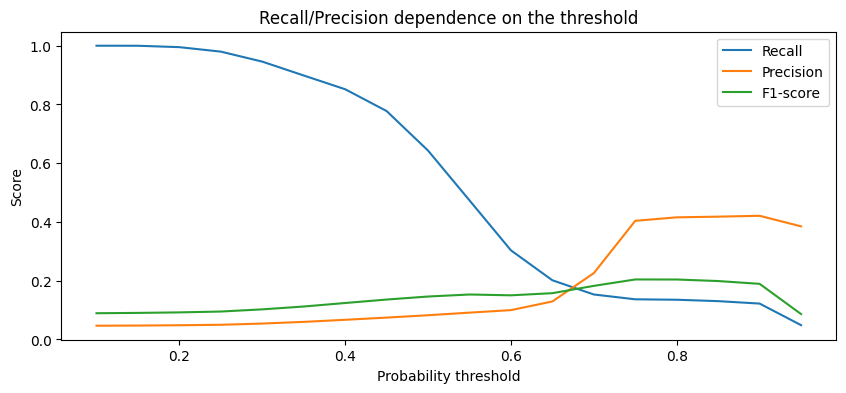

In [90]:
#Вычислим вероятности
y_test_proba_pred = log_reg.predict_proba(X_test_scaled)[:, 1]
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)

for threshold in thresholds:
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) 
ax.plot(thresholds, recall_scores, label='Recall')
ax.plot(thresholds, precision_scores, label='Precision')
ax.plot(thresholds, f1_scores, label='F1-score')
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend()

In [91]:
#Вручную подбираем оптимальный порог вероятностей
threshold_opt = 0.68
y_test_pred_opt_lr_all = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Вычисляем метрики
lr_all_accuracy = round(metrics.balanced_accuracy_score(y_test, y_test_pred_opt_lr_all),3)
lr_all_f1 = round(metrics.f1_score(y_test, y_test_pred_opt_lr_all, average="weighted"),3) 
print(f'Accuracy: {lr_all_accuracy}')
print(f'F1: {lr_all_f1}')
print(metrics.classification_report(y_test, y_test_pred_opt_lr_all))

Accuracy: 0.563
F1: 0.923
              precision    recall  f1-score   support

           0       0.96      0.96      0.96    209143
           1       0.17      0.17      0.17     10251

    accuracy                           0.92    219394
   macro avg       0.56      0.56      0.56    219394
weighted avg       0.92      0.92      0.92    219394



* Decision Tree Classifier

In [92]:
#Задаем пространство поиска гиперпараметров
parameters =  {'min_samples_leaf': list(np.linspace(2,10,5, dtype='int')), 
               'max_depth':list(np.linspace(1,40,20,dtype='int')), 
               'criterion':['entropy','gini']}
#Создаем и обучаем модель
model_cv = GridSearchCV(DecisionTreeClassifier(), 
                        parameters,
                        cv=3, scoring=('f1'), 
                        return_train_score=True)
model_cv.fit(X_train_s, y_train_s)
print(model_cv.best_params_)
print(model_cv.best_estimator_)
print(model_cv.best_score_)

{'criterion': 'entropy', 'max_depth': 33, 'min_samples_leaf': 2}
DecisionTreeClassifier(criterion='entropy', max_depth=33, min_samples_leaf=2)
0.8059078041973673


In [93]:
#Обучаем дерево решений на лучших параметрах и делаем предсказание
dt = DecisionTreeClassifier(max_depth= 35, min_samples_leaf= 2, criterion= 'entropy', random_state=42)
dt.fit(X_train_s, y_train_s)
y_pred = dt.predict(X_test_scaled)
#Вычисляем метрики
print(f'Accuracy: {round(metrics.balanced_accuracy_score(y_test, y_pred),3)}')
print(f'F1: {round(metrics.f1_score(y_test, y_pred, average="weighted"),3)}')

Accuracy: 0.69
F1: 0.795


Произведем подбор оптимального порога вероятностей

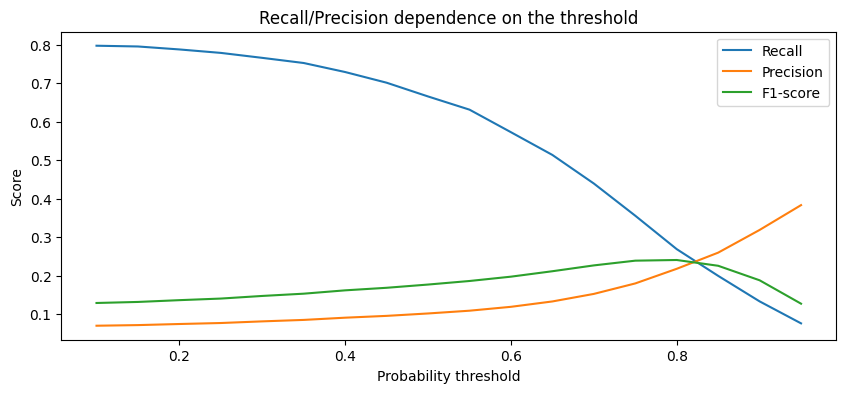

In [94]:
#Вычислим вероятности
y_test_proba_pred = dt.predict_proba(X_test_scaled)[:, 1]
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)

for threshold in thresholds:
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) 
ax.plot(thresholds, recall_scores, label='Recall')
ax.plot(thresholds, precision_scores, label='Precision')
ax.plot(thresholds, f1_scores, label='F1-score')
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend()

In [95]:
threshold_opt = 0.82
y_test_pred_opt_dt_all = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Вычисляем метрики
dt_all_accuracy = round(metrics.balanced_accuracy_score(y_test, y_test_pred_opt_dt_all),3)
dt_all_f1 = round(metrics.f1_score(y_test, y_test_pred_opt_dt_all, average="weighted"),3) 
print(f'Accuracy: {dt_all_accuracy}')
print(f'F1: {dt_all_f1}')
print(metrics.classification_report(y_test, y_test_pred_opt_dt_all))

Accuracy: 0.603
F1: 0.928
              precision    recall  f1-score   support

           0       0.96      0.96      0.96    209143
           1       0.23      0.25      0.24     10251

    accuracy                           0.93    219394
   macro avg       0.60      0.60      0.60    219394
weighted avg       0.93      0.93      0.93    219394



[Text(0.5, 1.0, 'Матрица ошибок дерева решений')]

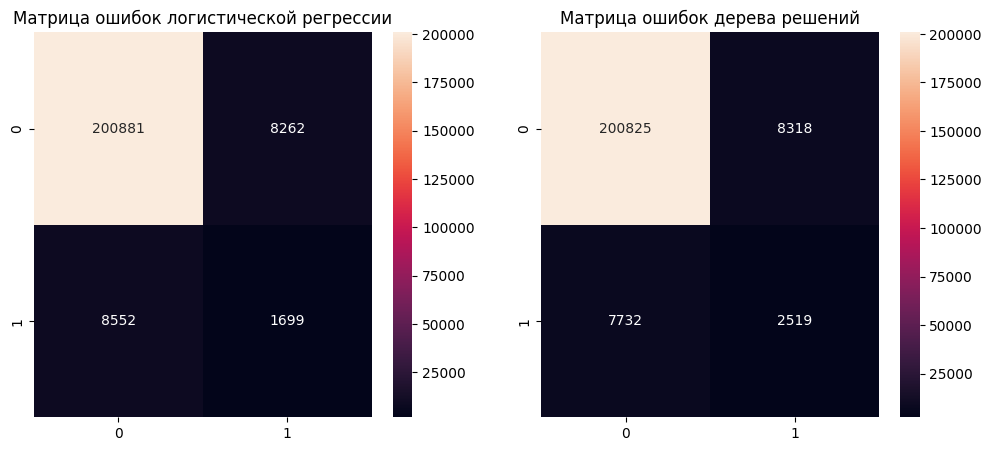

In [96]:
#Построим матрицу ошибок для моделей
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,5))
con_mat_lr = sns.heatmap(metrics.confusion_matrix(y_test, y_test_pred_opt_lr_all), annot=True, fmt='', ax=axes[0])
con_mat_lr.set(title='Матрица ошибок логистической регрессии')
con_mat_dt = sns.heatmap(metrics.confusion_matrix(y_test, y_test_pred_opt_dt_all), annot=True, fmt='', ax=axes[1])
con_mat_dt.set(title='Матрица ошибок дерева решений')

С небольшим отрывом модель дерева решений лучше справляется с предсказанием класса в условиях данной задачи. Сведем все полученные результаты в таблицу

In [ ]:
results = pd.DataFrame(data=[
   ['balanced_accuracy_score', lr_grants_accuracy, dt_grants_accuracy, rf_grants_accuracy, lr_all_accuracy, dt_grants_accuracy],
    ['f1_score', lr_grants_f1, dt_grants_f1, rf_grants_f1, lr_all_f1, dt_all_f1]], 
    columns=['metric', 'LogicticRegression(grants)', 'DecisionTree(grants)', 'RandomForest(grants)',
             'LogisticRegression(all)', 'DecisionTree(all)'])
results

,metric,LogicticRegression(grants),DecisionTree(grants),RandomForest(grants),LogisticRegression(all),DecisionTree(all)
0,balanced_accuracy_score,0.634,0.630,0.631,0.563,0.630
1,f1_score,0.978,0.978,0.978,0.923,0.928


На наборе данных с целевой переменной только грантов все три модели показывают практически одинаковый результат. С точки зрения эффективности целесообразно будет использовать модель логистической регресии. Для обобщенных данных незначительно выше показатели метрик для дерева решений.

#### Предсказание размера государственной поддержки

Теперь давайте попробуем предсказать количество денег, которое государство может выделить организации при условии одобрения выплаты. Будем решать задачу регрессии. Для этого сформируем датасет, в который войдут НКО, получившие гранты/субсидии/госконтракты

In [98]:
#Формируем датасет и разбиваем его на наборы для обучения и ответы
data = df[df['incomeTotal']>0]
X = data.drop(['grants','fedSub', 'contracts','incomeTotal'], axis=1)
y = data['incomeTotal']

In [99]:
#Делим данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [100]:
#Отбираем подходящие признаки
selector = SelectKBest(f_regression, k=7)
selector.fit(X_train, y_train)
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

#Нормализуем данные
scaler = preprocessing.StandardScaler()
scaler.fit(X_train_sel)                           
X_train_scaled = scaler.transform(X_train_sel)   
X_test_scaled = scaler.transform(X_test_sel)

В качестве baseline будем использовать предсказания модели линейной регрессии, метрики для оценки качества возьмем MAPE и R2

* Linear Regression

In [101]:
#Обучаем модель и делаем предсказание
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred = lin_reg.predict(X_test_scaled)
#Вычисляем метрики
print(f'MAPE: {round(metrics.mean_absolute_percentage_error(y_test, y_pred), 3)}')
print(f'R2: {round(metrics.r2_score(y_test, y_pred),3)}')

MAPE: 2245.15
R2: -0.0


Результат неудовлетворительный. Попробуем применить стохастический градиентный спуск

* SGD Regressor

In [102]:
#Обучаем модель и делаем предсказание
sgd = SGDRegressor(random_state=42)
sgd.fit(X_train_scaled, y_train)
y_pred = sgd.predict(X_test_scaled)
#Вычисляем метрики
print(f'MAPE: {round(metrics.mean_absolute_percentage_error(y_test, y_pred), 3)}')
print(f'R2: {round(metrics.r2_score(y_test, y_pred),3)}')

MAPE: 990.9
R2: -0.0


Результат неудовлетворительный. Попробуем использовать полиномиальную регрессию

* Polynomial Regression

In [103]:
#Генерируем полиномиальные признаки
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

In [104]:
#Обучаем модель и делаем предсказание
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train)
y_pred_poly = lr_poly.predict(X_test_poly)
#Вычисляем метрики
print(f'MAPE: {round(metrics.mean_absolute_percentage_error(y_test, y_pred_poly), 3)}')
print(f'R2: {round(metrics.r2_score(y_test, y_pred_poly),3)}')

MAPE: 1797.895
R2: 0.001


Результат неудовлетворительный. Попробуем применить дерево решений

* Decision Tree Regressor

In [105]:
#Обучаем модель и делаем предсказание
dt = DecisionTreeRegressor(random_state=42, max_depth=15, min_samples_leaf=2, criterion='absolute_error')
dt.fit(X_train_scaled, y_train)
y_pred = dt.predict(X_test_scaled)
#Вычисляем метрики
print(f'MAPE: {round(metrics.mean_absolute_percentage_error(y_test, y_pred), 3)}')
print(f'R2: {round(metrics.r2_score(y_test, y_pred),3)}')

MAPE: 272.288
R2: -0.0


Результат значительно выше, однако все еще является неудовлетворительным для решения задачи. Попробуем применить случайный лес

* Random Forest Regressor

In [106]:
#Обучаем модель и делаем предсказание
rf = RandomForestRegressor(criterion='absolute_error', max_depth=15, min_samples_leaf=2, n_estimators=200, random_state=42, verbose=True)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)
#Вычисляем метрики
print(f'MAPE: {round(metrics.mean_absolute_percentage_error(y_test, y_pred), 3)}')
print(f'R2: {round(metrics.r2_score(y_test, y_pred),3)}')

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.0min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  8.2min


MAPE: 218.062
R2: 0.01


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s


Попробуем применить градиентный бустинг

* Gradient Boosting Regressor

In [112]:
#Обучаем модель и делаем предсказание
GrBoo = GradientBoostingRegressor(n_estimators=100, max_depth=15, min_samples_leaf=2, random_state=42, verbose=True, learning_rate=0.1, criterion='friedman_mse')
GrBoo.fit(X_train_scaled, y_train)
y_pred = GrBoo.predict(X_test_scaled)
#Вычисляем метрики
print(f'MAPE: {round(metrics.mean_absolute_percentage_error(y_test, y_pred), 3)}')
print(f'R2: {round(metrics.r2_score(y_test, y_pred),3)}')

      Iter       Train Loss   Remaining Time 
         1 3742797548488800768.0000            5.35s
         2 3640986901210906112.0000            4.02s
         3 3556481041717697024.0000            3.69s
         4 3487862212365279232.0000            3.41s
         5 3432910005398447616.0000            3.25s
         6 3387574751543402496.0000            3.12s
         7 3350345948731218432.0000            3.04s
         8 3319984664421809664.0000            3.05s
         9 3293881361616068096.0000            3.00s
        10 3272340193679300096.0000            2.92s
        20 3185514181333300224.0000            2.48s
        30 3165781390303797760.0000            2.16s
        40 3157000545640416256.0000            1.83s
        50 3150758514379590656.0000            1.51s
        60 3147098176452502016.0000            1.21s
        70 3144716062031079424.0000            0.90s
        80 3143265909051314688.0000            0.61s
        90 3142518385070466560.0000            0.31s


Как мы видим, удовлетворительного результата добиться так и не удалось. Все модели недообучены и имеют высокое смещение. Поэтому считаю, что для выявления закономерности распределения размера государственной поддержки данных недостаточно, либо зависимость слишком сложная для описания ее приведенными выше средствами.

### Выводы:

Подводя итог всей работы, можно уверенно сказать, что существует зависимость вероятности получения от государства грантов/субсидий/контрактов от ряда характеристик организации и ее реально спрогнозировать.

В ходе выполнения работы были обработаны и сгенерированы признаки, выполнен их отбор и кодирование. На основе этих данных построена визуализация и обучение различных моделей с целью улучшить качество предсказаний.

Наилучший результат по метрикам (в условиях данного проекта) показали модели LogisticRegression и DecisionTreeClassifier с подбором гиперпараметров. Конечно, в реальных условиях ее качество находится под вопросом, однако данная работа позволила продемонстрировать знания и навыки, полученные в процессе обучения на курсе.
